In [1]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 227)

import warnings
warnings.filterwarnings('ignore')

# Import processing dataset

In [2]:
train_x = pd.read_csv("train_x.csv")
test_x = pd.read_csv("test_x.csv")
train_x_log = pd.read_csv("train_x_log.csv")
test_x_log = pd.read_csv("test_x_log.csv")
train_x_eng_with_KNN_TSNE_KMean = pd.read_csv("train_x_eng_with_KNN_TSNE_KMean.csv")
test_x_eng_with_KNN_TSNE_Kmean = pd.read_csv("test_x_eng_with_KNN_TSNE_Kmean.csv")
train_x_log_eng_with_KNN_TSNE_KMean = pd.read_csv("train_x_log_eng_with_KNN_TSNE_KMean.csv")
test_x_log_eng_with_KNN_TSNE_Kmean = pd.read_csv("test_x_log_eng_with_KNN_TSNE_Kmean.csv")
train_y_class = pd.read_csv("train_y_class.csv")
train_y_label = pd.read_csv("train_y_label.csv")

Submission = pd.read_csv("sampleSubmission.csv")

In [3]:
# Total dataset features to consider
print(train_x.shape)
print(test_x.shape)
print(train_x_log.shape)
print(test_x_log.shape)
print(train_x_eng_with_KNN_TSNE_KMean.shape)
print(test_x_eng_with_KNN_TSNE_Kmean.shape)
print(train_x_log_eng_with_KNN_TSNE_KMean.shape)
print(test_x_log_eng_with_KNN_TSNE_Kmean.shape)

# Label dataset
print(train_y_class.shape)
print(train_y_label.shape)

(61878, 93)
(144368, 93)
(61878, 93)
(144368, 93)
(61878, 227)
(144368, 227)
(61878, 227)
(144368, 227)
(61878, 9)
(61878, 1)


In [4]:
drop_columns_KNN = train_x_eng_with_KNN_TSNE_KMean.loc[:,"KNN_Feature_1":"KNN_Feature_36"].columns
drop_columns_KMeans = train_x_eng_with_KNN_TSNE_KMean.loc[:,"Class_0":"cluster_space_8"].columns
drop_columns_K_Class = train_x_eng_with_KNN_TSNE_KMean.loc[:,"Class_0":"Class_8"].columns

In [5]:
train_x_eng_with_KNN_TSNE_KMean_drop_KNN = train_x_eng_with_KNN_TSNE_KMean.drop(drop_columns_KNN,axis=1)
test_x_eng_with_KNN_TSNE_Kmean_drop_KNN = test_x_eng_with_KNN_TSNE_Kmean.drop(drop_columns_KNN,axis=1)
train_x_eng_with_KNN_TSNE_KMean_drop_KMeans = train_x_eng_with_KNN_TSNE_KMean.drop(drop_columns_KMeans,axis=1)
test_x_eng_with_KNN_TSNE_Kmean_drop_KMeans = test_x_eng_with_KNN_TSNE_Kmean.drop(drop_columns_KMeans,axis=1)
train_x_eng_with_KNN_TSNE_KMean_drop_K_Class = train_x_eng_with_KNN_TSNE_KMean.drop(drop_columns_K_Class,axis=1)
test_x_eng_with_KNN_TSNE_Kmean_drop_K_Class = test_x_eng_with_KNN_TSNE_Kmean.drop(drop_columns_K_Class,axis=1)

In [6]:
print(train_x_eng_with_KNN_TSNE_KMean_drop_KNN.shape)
print(test_x_eng_with_KNN_TSNE_Kmean_drop_KNN.shape)
print(train_x_eng_with_KNN_TSNE_KMean_drop_KMeans.shape)
print(test_x_eng_with_KNN_TSNE_Kmean_drop_KMeans.shape)
print(train_x_eng_with_KNN_TSNE_KMean_drop_K_Class.shape)
print(test_x_eng_with_KNN_TSNE_Kmean_drop_K_Class.shape)

(61878, 191)
(144368, 191)
(61878, 209)
(144368, 209)
(61878, 218)
(144368, 218)


# 1. XGBoost, Grid Search with 
# train_x_eng_with_KNN_TSNE_KMean_drop_KNN, train_y_label

In [7]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pickle

In [8]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [9]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0],                       # 3rd
                          'max_depth': [6],                     # 1st to tune
                          'min_child_weight': [0],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.78],                   # 4th
                          'colsample_bytree': [0.78],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [0],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [256],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["multi:softprob"],
                          "eval_metric": ["mlogloss"],
                          "num_class": [9],
                          "seed": [0]
                         }                

In [10]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBClassifier()

In [11]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 4, iid = False)

In [12]:
xgboost_grid.fit(train_x_eng_with_KNN_TSNE_KMean_drop_KNN,train_y_label)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.1], 'gamma': [0], 'max_depth': [6], 'min_child_weight': [0], 'max_delta_step': [0], 'subsample': [0.78], 'colsample_bytree': [0.78], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [0], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [256], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['multi:softprob'], 'eval_metric': ['mlogloss'], 'num_class': [9], 'seed': [0]},
       pr

In [13]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_accuracy_score = best_rf.score(train_x_eng_with_KNN_TSNE_KMean_drop_KNN,train_y_label)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_accuracy_score)
print(best_score)
print(best_accuracy_score)
print(best_rf)

0.8285017156560575
0.9255632050163224
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.78, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=0, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.78, verbosity=1)


In [14]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

[0.8285017156560575]
[0.9255632050163224]
[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.78, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=0, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.78, verbosity=1)]


# XGBoost_test_x_eng_with_KNN_TSNE_Kmean, Prediction for Ensemble Model before optimize boosting

In [15]:
XGBoost_test_x_eng_prior_pred = best_rf.predict_proba(test_x_eng_with_KNN_TSNE_Kmean_drop_KNN)

In [16]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_eng_prior_pred

In [17]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_eng_prior_pred_drop_KNN.csv",index=False)

# XGBoost_train_x_eng_with_KNN_TSNE_Kmean, Prediction for Ensemble Model before optimize boosting

In [18]:
XGBoost_train_x_eng_prior_pred = best_rf.predict_proba(train_x_eng_with_KNN_TSNE_KMean_drop_KNN)

In [19]:
XGBoost_train_x_eng_prior_pred = pd.DataFrame(XGBoost_train_x_eng_prior_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [20]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_eng_prior_pred.to_csv("XGBoost_train_x_eng_prior_pred_drop_KNN.csv",index=False)

# Create XGBoost's DMatrix, to boosting up the learning rate

In [21]:
trainDMat = xgb.DMatrix(data = train_x_eng_with_KNN_TSNE_KMean_drop_KNN, label = train_y_label)

In [22]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)
num_boost_round = 15000
early_stopping_rounds = 50
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [23]:
hyperparameters_boosting = {'learning_rate': 0.1,               # 6th when boosting
                          'gamma': 0,                       # 3rd
                          'max_depth': 6,                     # 1st to tune
                          'min_child_weight': 0,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.78,                   # 4th
                          'colsample_bytree': 0.78,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 0,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 256,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "multi:softprob",
                          "eval_metric": "mlogloss",
                          "num_class": 9,
                          "seed": 0
                         }                

In [24]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 4, #same as CV
    metrics = {'merror'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-merror:0.180737+0.000905787	test-merror:0.201768+0.00310368
[1]	train-merror:0.174613+0.00149797	test-merror:0.195708+0.00371719
[2]	train-merror:0.172161+0.0014099	test-merror:0.193009+0.00369271
[3]	train-merror:0.170454+0.00170055	test-merror:0.191506+0.00301664
[4]	train-merror:0.168794+0.0010269	test-merror:0.190197+0.00308317
[5]	train-merror:0.167367+0.0013956	test-merror:0.189744+0.00258898
[6]	train-merror:0.166484+0.00145239	test-merror:0.189389+0.00216608
[7]	train-merror:0.165433+0.001646	test-merror:0.188952+0.00187789
[8]	train-merror:0.164636+0.00148717	test-merror:0.188597+0.00182625
[9]	train-merror:0.164054+0.00159338	test-merror:0.188177+0.00192171
[10]	train-merror:0.163235+0.0017251	test-merror:0.187627+0.00141216
[11]	train-merror:0.162756+0.00152277	test-merror:0.186949+0.00154964
[12]	train-merror:0.161818+0.00158082	test-merror:0.186157+0.00207437
[13]	train-merror:0.161398+0.00154718	test-merror:0.186108+0.00195732
[14]	train-merror:0.160919+0.001646

[118]	train-merror:0.0955485+0.0016693	test-merror:0.172404+0.0041294
[119]	train-merror:0.094864+0.00170989	test-merror:0.172307+0.00383394
[120]	train-merror:0.094056+0.00164044	test-merror:0.172048+0.00363887
[121]	train-merror:0.093458+0.00161592	test-merror:0.172129+0.00358332
[122]	train-merror:0.0926073+0.00149388	test-merror:0.172161+0.00359962
[123]	train-merror:0.0921005+0.00145915	test-merror:0.172177+0.00393545
[124]	train-merror:0.0912495+0.00147535	test-merror:0.172177+0.0038324
[125]	train-merror:0.0905597+0.00142232	test-merror:0.17221+0.00387686
[126]	train-merror:0.0898165+0.00140761	test-merror:0.172258+0.00385378
[127]	train-merror:0.0892995+0.00133754	test-merror:0.171919+0.00384901
[128]	train-merror:0.0886907+0.00108216	test-merror:0.172129+0.00381611
[129]	train-merror:0.0880605+0.00108635	test-merror:0.172081+0.00378684
[130]	train-merror:0.087317+0.00103027	test-merror:0.171903+0.00380163
[131]	train-merror:0.0866705+0.00103487	test-merror:0.172145+0.00365991


[232]	train-merror:0.0382905+0.000725752	test-merror:0.169737+0.00306348
[233]	train-merror:0.0380428+0.000651009	test-merror:0.169753+0.00299809
[234]	train-merror:0.037881+0.000594313	test-merror:0.169656+0.00297182
[235]	train-merror:0.0375308+0.000607841	test-merror:0.169559+0.00296818
[236]	train-merror:0.0372183+0.000469794	test-merror:0.169721+0.00310219
[237]	train-merror:0.0369655+0.000528895	test-merror:0.169883+0.00313897
[238]	train-merror:0.0366153+0.000535951	test-merror:0.16964+0.00299334
[239]	train-merror:0.036265+0.000585283	test-merror:0.169624+0.00308544
[240]	train-merror:0.0359363+0.000609214	test-merror:0.169576+0.00301335
[241]	train-merror:0.0356185+0.000591232	test-merror:0.169608+0.00323205
[242]	train-merror:0.035387+0.000517675	test-merror:0.169592+0.00322033
[243]	train-merror:0.0352683+0.000570472	test-merror:0.169689+0.00306362
[244]	train-merror:0.0349397+0.000613111	test-merror:0.169656+0.0031526
[245]	train-merror:0.0346217+0.000545587	test-merror:0.1

# Finalise XGBoost Model

In [25]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

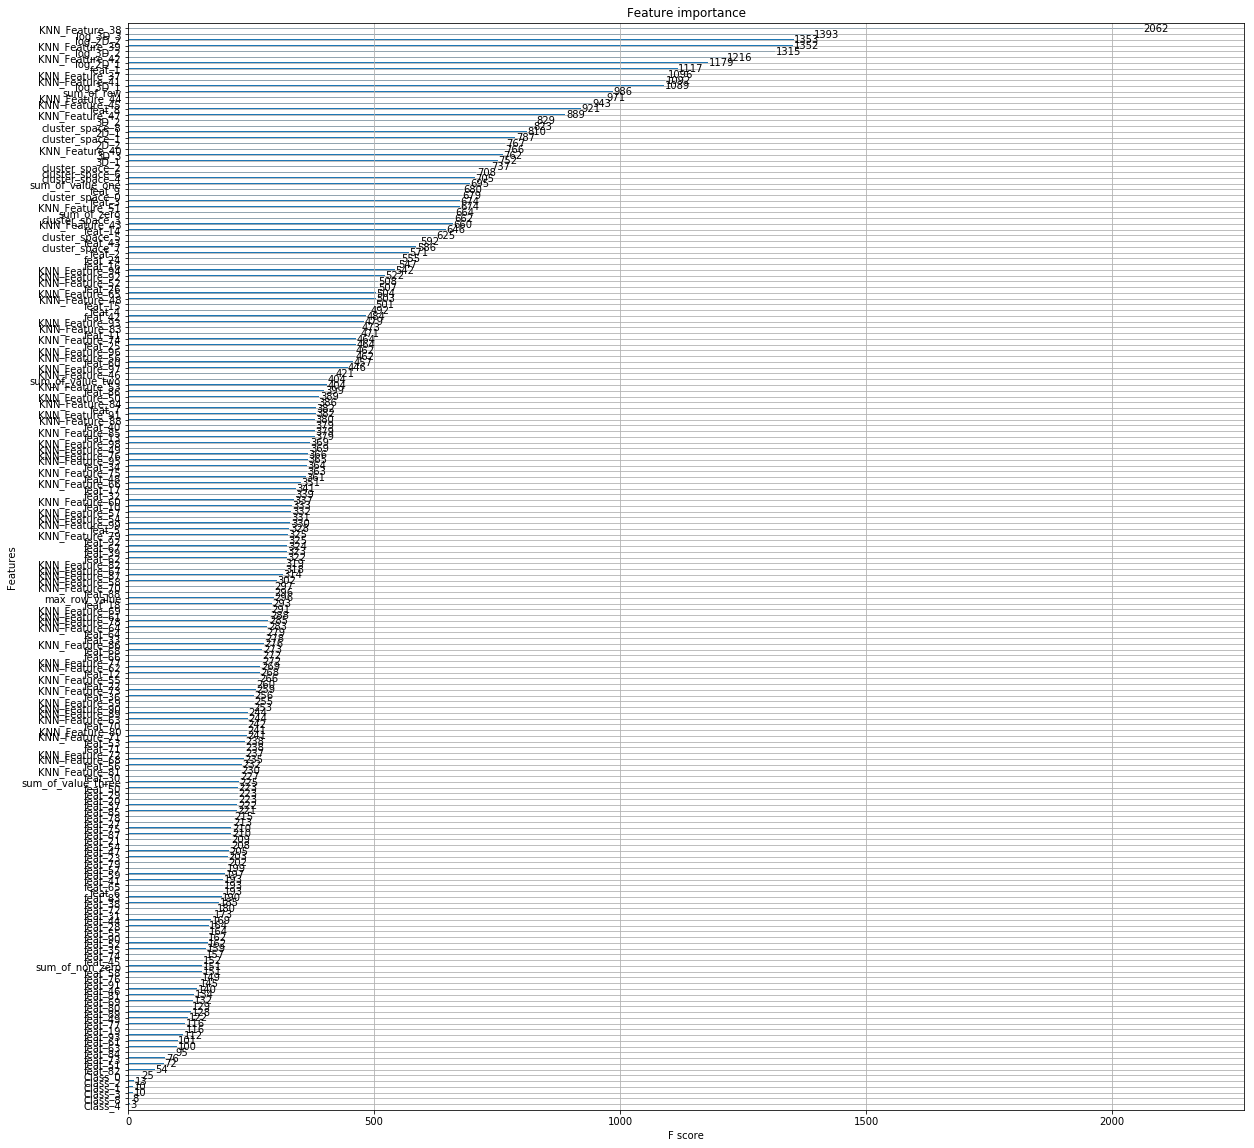

In [26]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgbFinal, ax=ax)

# XGBoost_test_x_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model After optimize boosting

In [27]:
XGBoost_test_x_eng_pred = xgbFinal.predict(xgb.DMatrix(test_x_eng_with_KNN_TSNE_Kmean_drop_KNN))

In [28]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_eng_pred

In [29]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_eng_pred_drop_KNN.csv",index=False)

# XGBoost_train_x_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model After optimize boosting

In [30]:
XGBoost_train_x_eng_pred = xgbFinal.predict(xgb.DMatrix(train_x_eng_with_KNN_TSNE_KMean_drop_KNN))

In [31]:
XGBoost_train_x_eng_pred = pd.DataFrame(XGBoost_train_x_eng_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [32]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_eng_pred.to_csv("XGBoost_train_x_eng_pred_drop_KNN.csv",index=False)

# Saving the final model

In [33]:
pickle.dump(xgbFinal, open("XGBoost_train_x_eng_model_drop_KNN.pickle.dat", "wb"))

# Loading the final model

In [ ]:
XGBoost_train_x_eng_model = pickle.load(open("XGBoost_train_x_eng_model_drop_KNN.pickle.dat", "rb"))

In [ ]:
# Re-forecast the prediction to verify the model
XGBoost_train_x_eng_model_pred = XGBoost_train_x_eng_model.predict(xgb.DMatrix(test_x_log))

# 2. XGBoost, Grid Search with 
# train_x_eng_with_KNN_TSNE_KMean_drop_KMeans, train_y_label

In [34]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pickle

In [35]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [36]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0],                       # 3rd
                          'max_depth': [6],                     # 1st to tune
                          'min_child_weight': [0],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.78],                   # 4th
                          'colsample_bytree': [0.78],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [0],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [256],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["multi:softprob"],
                          "eval_metric": ["mlogloss"],
                          "num_class": [9],
                          "seed": [0]
                         }                

In [37]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBClassifier()

In [38]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 4, iid = False)

In [39]:
xgboost_grid.fit(train_x_eng_with_KNN_TSNE_KMean_drop_KMeans,train_y_label)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.1], 'gamma': [0], 'max_depth': [6], 'min_child_weight': [0], 'max_delta_step': [0], 'subsample': [0.78], 'colsample_bytree': [0.78], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [0], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [256], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['multi:softprob'], 'eval_metric': ['mlogloss'], 'num_class': [9], 'seed': [0]},
       pr

In [40]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_accuracy_score = best_rf.score(train_x_eng_with_KNN_TSNE_KMean_drop_KMeans,train_y_label)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_accuracy_score)
print(best_score)
print(best_accuracy_score)
print(best_rf)

0.9019362194143147
0.9887682213387634
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.78, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=0, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.78, verbosity=1)


In [41]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

[0.9019362194143147]
[0.9887682213387634]
[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.78, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=0, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.78, verbosity=1)]


# XGBoost_test_x_log_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model before optimize boosting

In [43]:
XGBoost_test_x_log_eng_prior_pred = best_rf.predict_proba(test_x_eng_with_KNN_TSNE_Kmean_drop_KMeans)

In [44]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_log_eng_prior_pred

In [45]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_log_eng_prior_pred_drop_KMeans.csv",index=False)

# XGBoost_train_x_log_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model before optimize boosting

In [46]:
XGBoost_train_x_log_eng_prior_pred = best_rf.predict_proba(train_x_eng_with_KNN_TSNE_KMean_drop_KMeans)

In [47]:
XGBoost_train_x_log_eng_prior_pred = pd.DataFrame(XGBoost_train_x_log_eng_prior_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [48]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_log_eng_prior_pred.to_csv("XGBoost_train_x_log_eng_prior_pred_drop_KMeans.csv",index=False)

# Create XGBoost's DMatrix, to boosting up the learning rate

In [49]:
trainDMat = xgb.DMatrix(data = train_x_eng_with_KNN_TSNE_KMean_drop_KMeans, label = train_y_label)

In [50]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)
num_boost_round = 15000
early_stopping_rounds = 50
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [51]:
hyperparameters_boosting = {'learning_rate': 0.1,               # 6th when boosting
                          'gamma': 0,                       # 3rd
                          'max_depth': 6,                     # 1st to tune
                          'min_child_weight': 0,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.78,                   # 4th
                          'colsample_bytree': 0.78,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 0,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 256,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "multi:softprob",
                          "eval_metric": "mlogloss",
                          "num_class": 9,
                          "seed": 0
                         }                

In [52]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 4, #same as CV
    metrics = {'merror'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-merror:0.0875107+0.0018945	test-merror:0.100941+0.00284436
[1]	train-merror:0.0817737+0.00130595	test-merror:0.0986297+0.00239604
[2]	train-merror:0.077335+0.00161216	test-merror:0.097547+0.00259207
[3]	train-merror:0.0743778+0.00137967	test-merror:0.096577+0.0014602
[4]	train-merror:0.0729122+0.00132469	test-merror:0.0964803+0.00147807
[5]	train-merror:0.0710055+0.00189952	test-merror:0.0961248+0.0019587
[6]	train-merror:0.0700247+0.00160675	test-merror:0.0960117+0.00223056
[7]	train-merror:0.0685702+0.00159487	test-merror:0.0958823+0.00223274
[8]	train-merror:0.0676597+0.00134494	test-merror:0.0955108+0.00237888
[9]	train-merror:0.0667602+0.00148211	test-merror:0.095656+0.0023505
[10]	train-merror:0.0656347+0.00150251	test-merror:0.0951065+0.00260022
[11]	train-merror:0.065107+0.0014157	test-merror:0.0949288+0.00228224
[12]	train-merror:0.064056+0.00124448	test-merror:0.0953973+0.00266195
[13]	train-merror:0.0633612+0.00114396	test-merror:0.0947187+0.0027828
[14]	train-merr

# Finalise XGBoost Model

In [53]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

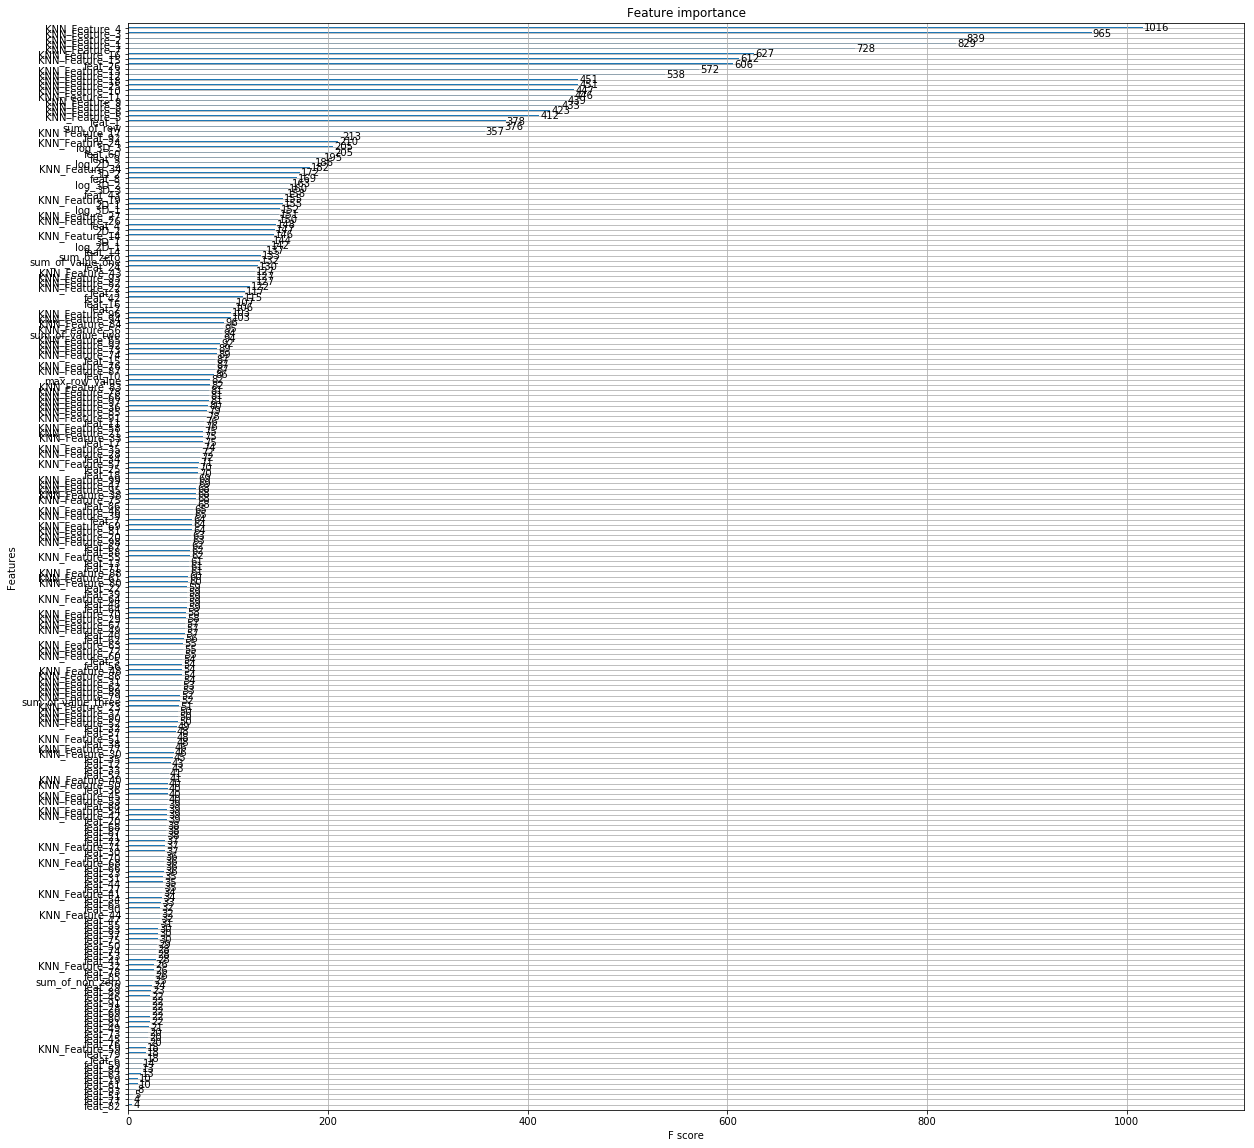

In [54]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgbFinal, ax=ax)

# XGBoost_test_x_log_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model After optimize boosting

In [56]:
XGBoost_test_x_log_eng_pred = xgbFinal.predict(xgb.DMatrix(test_x_eng_with_KNN_TSNE_Kmean_drop_KMeans))

In [57]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_log_eng_pred

In [58]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_log_eng_pred_drop_KMeans.csv",index=False)

# XGBoost_train_x_log_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model After optimize boosting

In [59]:
XGBoost_train_x_log_eng_pred = xgbFinal.predict(xgb.DMatrix(train_x_eng_with_KNN_TSNE_KMean_drop_KMeans))

In [60]:
XGBoost_train_x_log_eng_pred = pd.DataFrame(XGBoost_train_x_log_eng_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [61]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_log_eng_pred.to_csv("XGBoost_train_x_log_eng_pred_drop_KMeans.csv",index=False)

# Saving the final model

In [62]:
pickle.dump(xgbFinal, open("XGBoost_train_x_log_eng_model_drop_KMeans.pickle.dat", "wb"))

# Loading the final model

In [ ]:
XGBoost_train_x_log_eng_model = pickle.load(open("XGBoost_train_x_log_eng_model_drop_KMeans.pickle.dat", "rb"))

In [ ]:
# Re-forecast the prediction to verify the model
XGBoost_train_x_log_eng_model_pred = XGBoost_train_x_log_eng_model.predict(xgb.DMatrix(test_x_log_eng_with_KNN_TSNE_Kmean))

# 3. XGBoost, Grid Search with 
# train_x_eng_with_KNN_TSNE_KMean_drop_K_Class, train_y_label

In [63]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pickle

In [64]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [65]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0],                       # 3rd
                          'max_depth': [6],                     # 1st to tune
                          'min_child_weight': [0],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.78],                   # 4th
                          'colsample_bytree': [0.78],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [0],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [256],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["multi:softprob"],
                          "eval_metric": ["mlogloss"],
                          "num_class": [9],
                          "seed": [0]
                         }                

In [66]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBClassifier()

In [67]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 4, iid = False)

In [68]:
xgboost_grid.fit(train_x_eng_with_KNN_TSNE_KMean_drop_K_Class,train_y_label)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.1], 'gamma': [0], 'max_depth': [6], 'min_child_weight': [0], 'max_delta_step': [0], 'subsample': [0.78], 'colsample_bytree': [0.78], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [0], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [256], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['multi:softprob'], 'eval_metric': ['mlogloss'], 'num_class': [9], 'seed': [0]},
       pr

In [69]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_accuracy_score = best_rf.score(train_x_eng_with_KNN_TSNE_KMean_drop_K_Class,train_y_label)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_accuracy_score)
print(best_score)
print(best_accuracy_score)
print(best_rf)

0.9028574762298146
0.9876369630563366
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.78, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=0, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.78, verbosity=1)


In [70]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

[0.9028574762298146]
[0.9876369630563366]
[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.78, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=0, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.78, verbosity=1)]


# XGBoost_test_x_log_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model before optimize boosting

In [71]:
XGBoost_test_x_log_eng_prior_pred = best_rf.predict_proba(test_x_eng_with_KNN_TSNE_Kmean_drop_K_Class)

In [72]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_log_eng_prior_pred

In [73]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_log_eng_prior_pred_drop_K_Class.csv",index=False)

# XGBoost_train_x_log_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model before optimize boosting

In [74]:
XGBoost_train_x_log_eng_prior_pred = best_rf.predict_proba(train_x_eng_with_KNN_TSNE_KMean_drop_K_Class)

In [75]:
XGBoost_train_x_log_eng_prior_pred = pd.DataFrame(XGBoost_train_x_log_eng_prior_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [76]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_log_eng_prior_pred.to_csv("XGBoost_train_x_log_eng_prior_pred_drop_K_Class.csv",index=False)

# Create XGBoost's DMatrix, to boosting up the learning rate

In [77]:
trainDMat = xgb.DMatrix(data = train_x_eng_with_KNN_TSNE_KMean_drop_K_Class, label = train_y_label)

In [78]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)
num_boost_round = 15000
early_stopping_rounds = 50
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [79]:
hyperparameters_boosting = {'learning_rate': 0.1,               # 6th when boosting
                          'gamma': 0,                       # 3rd
                          'max_depth': 6,                     # 1st to tune
                          'min_child_weight': 0,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.78,                   # 4th
                          'colsample_bytree': 0.78,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 0,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 256,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "multi:softprob",
                          "eval_metric": "mlogloss",
                          "num_class": 9,
                          "seed": 0
                         }                

In [80]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 4, #same as CV
    metrics = {'merror'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-merror:0.0848178+0.000568565	test-merror:0.0994218+0.00202636
[1]	train-merror:0.079899+0.00103183	test-merror:0.09968+0.00149886
[2]	train-merror:0.076861+0.00091789	test-merror:0.097466+0.000722736
[3]	train-merror:0.0739573+0.00114645	test-merror:0.0970783+0.000330569
[4]	train-merror:0.071851+0.000932907	test-merror:0.09606+0.000979305
[5]	train-merror:0.0697877+0.000693763	test-merror:0.0952358+0.000946201
[6]	train-merror:0.0685218+0.000915912	test-merror:0.0946865+0.00147697
[7]	train-merror:0.067698+0.00076732	test-merror:0.094654+0.00143987
[8]	train-merror:0.0662273+0.000940971	test-merror:0.0951065+0.00133361
[9]	train-merror:0.0650152+0.000870211	test-merror:0.0944762+0.00146145
[10]	train-merror:0.0643308+0.000903019	test-merror:0.0941368+0.00144544
[11]	train-merror:0.063178+0.000883424	test-merror:0.0942012+0.001363
[12]	train-merror:0.0621333+0.000880891	test-merror:0.0943632+0.00111395
[13]	train-merror:0.0615565+0.00084372	test-merror:0.0942335+0.00108271
[1

# Finalise XGBoost Model

In [81]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

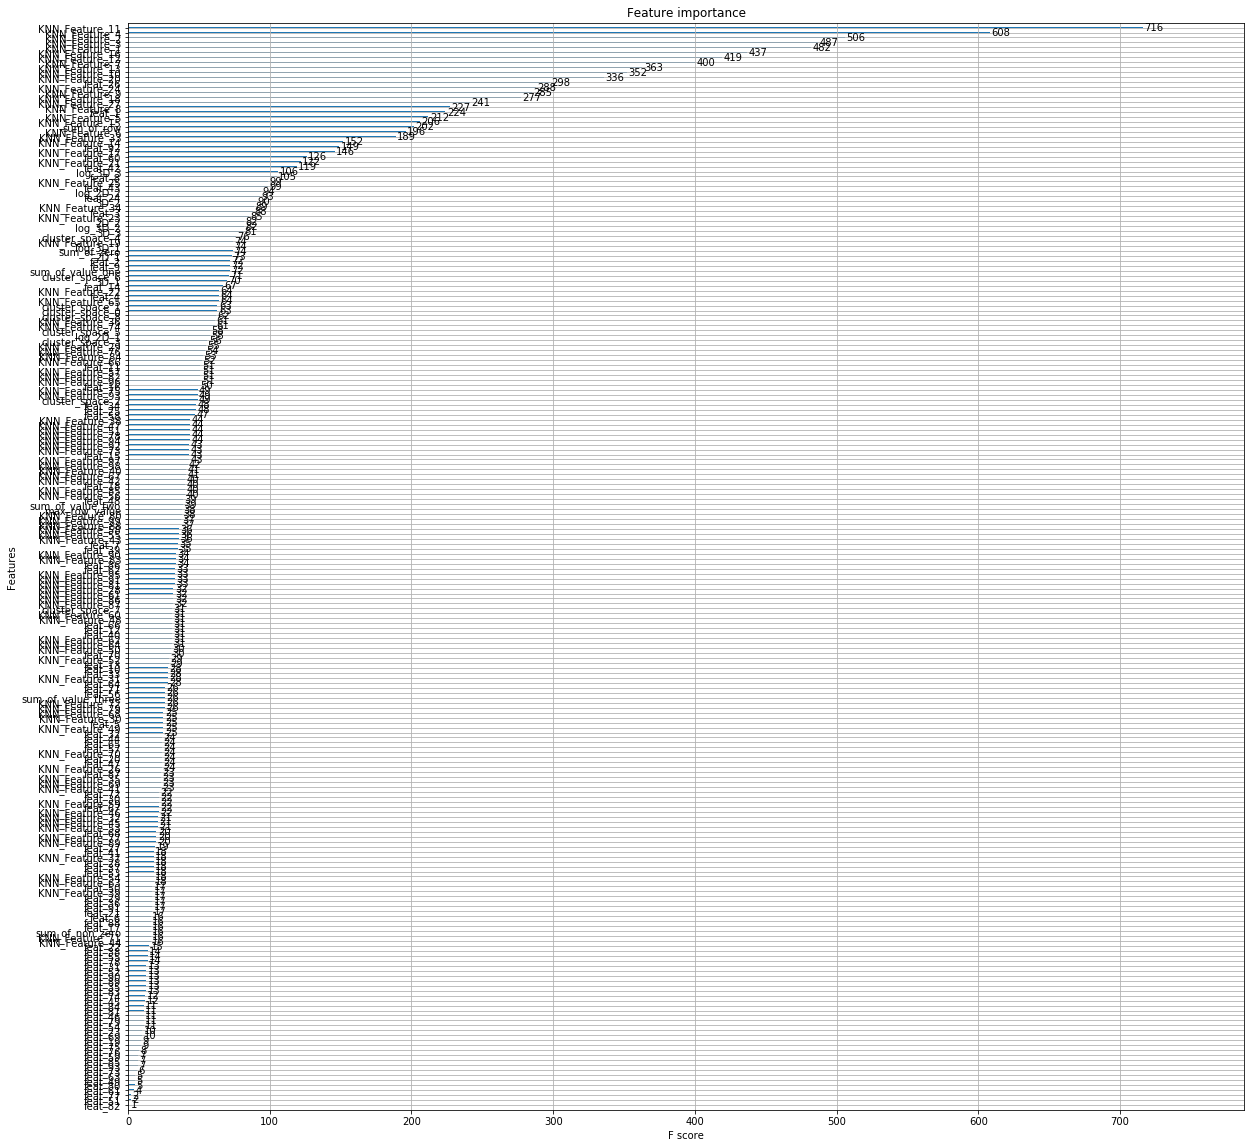

In [82]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgbFinal, ax=ax)

# XGBoost_test_x_log_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model After optimize boosting

In [83]:
XGBoost_test_x_log_eng_pred = xgbFinal.predict(xgb.DMatrix(test_x_eng_with_KNN_TSNE_Kmean_drop_K_Class))

In [84]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_log_eng_pred

In [85]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_log_eng_pred_drop_K_Class.csv",index=False)

# XGBoost_train_x_log_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model After optimize boosting

In [86]:
XGBoost_train_x_log_eng_pred = xgbFinal.predict(xgb.DMatrix(train_x_eng_with_KNN_TSNE_KMean_drop_K_Class))

In [87]:
XGBoost_train_x_log_eng_pred = pd.DataFrame(XGBoost_train_x_log_eng_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [88]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_log_eng_pred.to_csv("XGBoost_train_x_log_eng_pred_drop_K_Class.csv",index=False)

# Saving the final model

In [89]:
pickle.dump(xgbFinal, open("XGBoost_train_x_log_eng_model_drop_KMeans.pickle.dat", "wb"))

# Loading the final model

In [ ]:
XGBoost_train_x_log_eng_model = pickle.load(open("XGBoost_train_x_log_eng_model_drop_KMeans.pickle.dat", "rb"))

In [ ]:
# Re-forecast the prediction to verify the model
XGBoost_train_x_log_eng_model_pred = XGBoost_train_x_log_eng_model.predict(xgb.DMatrix(test_x_log_eng_with_KNN_TSNE_Kmean))